# Airbnb

Airbnb rent price forecasting.

## Library

In [1]:
from re import sub

from numpy import hstack, sqrt, mean

from pandas import read_csv, DataFrame

from sklearn import preprocessing, model_selection, metrics

from catboost import CatBoostRegressor, Pool

## Data

Data exploration, transformation and selection.

In [2]:
data = read_csv(
    './data/airbnb.csv',
    usecols=[
        'neighbourhood_cleansed',
        'accommodates',
        'minimum_minimum_nights',
        'price'
    ],
    converters={
        'price': lambda value: float(sub(r'[^\d\-.]', '', value))
    }
)

In [3]:
data.head()

,neighbourhood_cleansed,accommodates,price,minimum_minimum_nights
0,Copacabana,5,350.0,5
1,Ipanema,2,296.0,3
2,Copacabana,3,387.0,2
3,Ipanema,2,172.0,2
4,Copacabana,2,260.0,3


In [4]:
data.describe()

,accommodates,price,minimum_minimum_nights
count,24549.000000,24549.000000,24549.000000
mean,4.175445,1029.592285,4.933643
std,2.488227,5403.742297,20.130429
min,0.000000,0.000000,1.000000
25%,2.000000,250.000000,2.000000
50%,4.000000,479.000000,2.000000
75%,5.000000,900.000000,4.000000
max,16.000000,650476.000000,1000.000000


In [5]:
data.dropna(how='any', inplace=True)

In [6]:
data.drop(data[(data.accommodates <= 0) | (data.price <= 0)].index, inplace=True)

In [7]:
label_encoder = preprocessing.LabelEncoder()

data.neighbourhood_cleansed = label_encoder.fit_transform(data.neighbourhood_cleansed)

In [8]:
features = preprocessing.normalize(data.price.values.reshape(-1,1), axis=0)

data.price = hstack(features)

In [9]:
train, labels = data[['neighbourhood_cleansed', 'accommodates', 'minimum_minimum_nights']], data['price']

In [10]:
x, x_test, y, y_test = model_selection.train_test_split(train, labels, test_size=0.25, train_size=0.75)

## Model

Regression model and random search optimization.

In [11]:
model = CatBoostRegressor(
    task_type='GPU',
    verbose=False
)

In [12]:
%%capture

grid = {
    'iterations': [100, 200, 400, 1000, 2000, 4000],
    'learning_rate': [0.01, 0.02, 0.04, 0.1, 0.2, 0.4],
    'depth': [1, 2, 4, 6, 10, 14],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11]
}

model.randomized_search(
    grid,
    X=x,
    y=y,
    verbose=False,
    plot=False,
)

bestTest = 0.004409368075
bestIteration = 113
bestTest = 0.004409905658
bestIteration = 113
bestTest = 0.004409250592
bestIteration = 252
bestTest = 0.004402712261
bestIteration = 271
bestTest = 0.004400725853
bestIteration = 14
bestTest = 0.004402042563
bestIteration = 198
bestTest = 0.004399844072
bestIteration = 122
bestTest = 0.004400360516
bestIteration = 19
bestTest = 0.004422088452
bestIteration = 3
bestTest = 0.004398662645
bestIteration = 103
Training on fold [0/3]
bestTest = 0.00392581907
bestIteration = 139
Training on fold [1/3]
bestTest = 0.004042456852
bestIteration = 391
Training on fold [2/3]
bestTest = 0.01053698137
bestIteration = 334


## Metric

In [13]:
predictions = model.predict(x_test)

In [14]:
DataFrame({
    'feature_importance': model.get_feature_importance(),
    'feature_names': x.columns,
}).sort_values(by=['feature_importance'], ascending=False)

,feature_importance,feature_names
0,41.085459,neighbourhood_cleansed
2,35.956268,minimum_minimum_nights
1,22.958273,accommodates


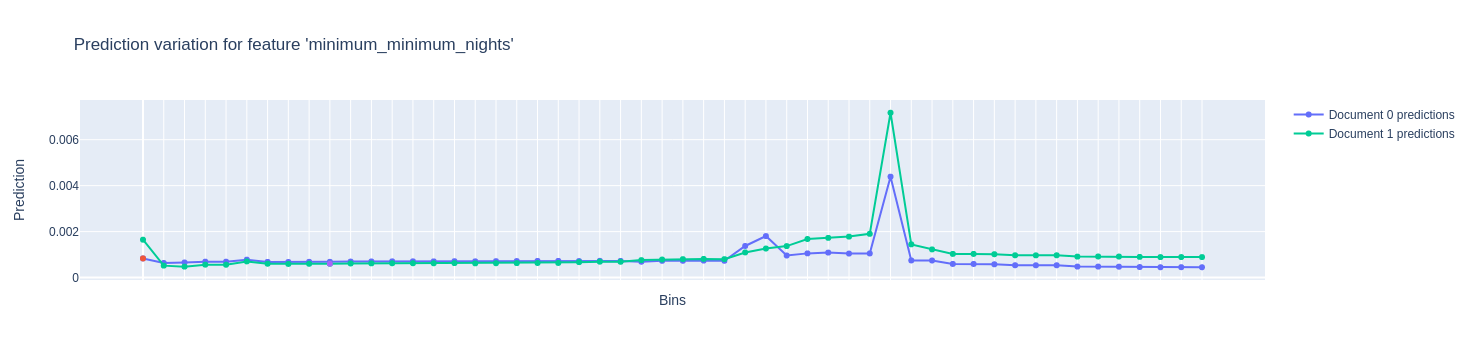

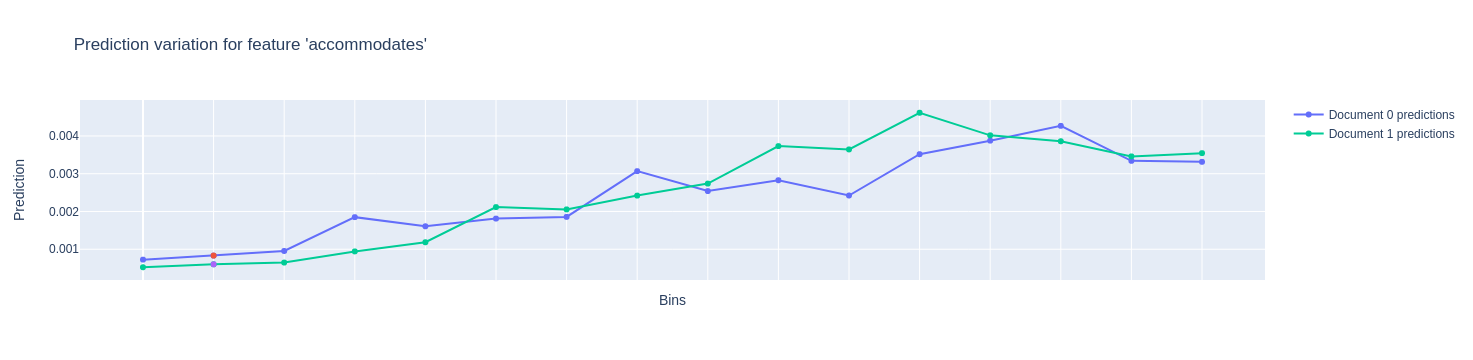

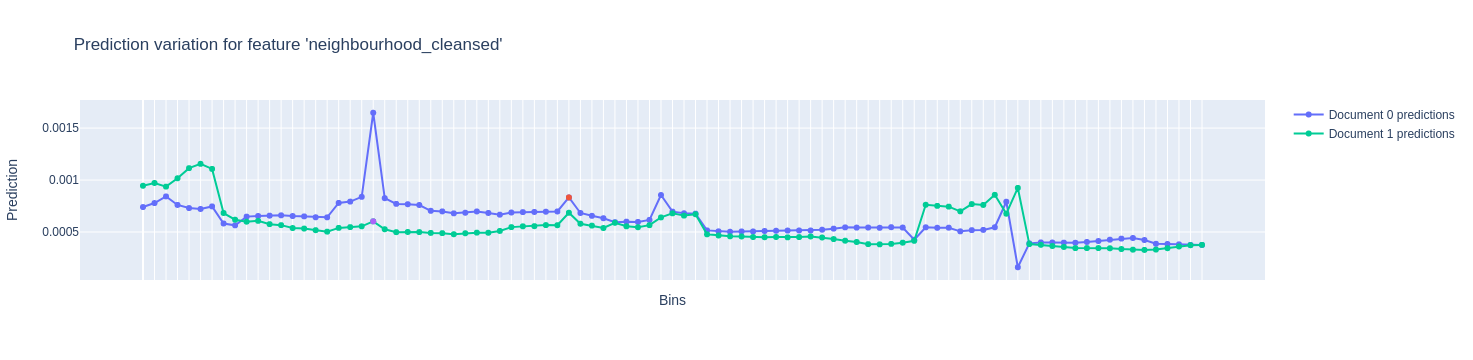

([{2: [0.0016477166220323358,
    0.0005191133130514336,
    0.00047611789687607153,
    0.0005610644644641338,
    0.0005580059314992392,
    0.0007029951810514357,
    0.0006026234830801558,
    0.0005935008197371916,
    0.0006015538483598037,
    0.0006025219670863224,
    0.0006130388679156384,
    0.0006174165487681238,
    0.0006231540009383751,
    0.0006240621483374342,
    0.0006221171722035068,
    0.0006285582424442326,
    0.0006167562808175875,
    0.0006243650765443975,
    0.0006294758663162314,
    0.0006341795157541741,
    0.0006363904796390374,
    0.0006713355354978079,
    0.0006914212188294799,
    0.000687766481466956,
    0.0007600887508384391,
    0.0007838443137880846,
    0.00080189355621052,
    0.0008104016401758729,
    0.0008019978143450901,
    0.0010933496752577598,
    0.001263412096915606,
    0.001370182167545697,
    0.0016783770765488315,
    0.0017272706863212806,
    0.001782155357479387,
    0.0019027845309703695,
    0.0071720824199711375,
   

In [15]:
train_pool = Pool(x, y)

train_pool_slice = train_pool.slice([1, 4])

prediction_diff = model.get_feature_importance(
    train_pool_slice,
    type='PredictionDiff',
    prettified=True,
    verbose=False,
)

model.plot_predictions(
    data=train_pool_slice,
    features_to_change=prediction_diff['Feature Id'],
    plot=True
)

In [16]:
rmse = sqrt(metrics.mean_squared_error(y_test, predictions))

print('RMSE in Y units:', mean(rmse))

RMSE in Y units: 0.0035015222365704975


In [17]:
model.get_scale_and_bias()

(1.0, 0.0012295992346480489)

## Export

In [18]:
model.save_model('model.cbm', format='cbm')